In [ ]:
import os
import json
from pathlib import Path

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from feature_descriptors import HogFeatureDescriptor

### Crop images

In [ ]:
VIDEOS_EXTENSIONS = ('.mov', '.mp4')
DATA_ROOT_DIR = Path('../data/vriv/source')
PREPROCESSED_DATA_SAVE_DIR = Path('../data/vriv/preprocessed')
FRAMES_SAVE_DIR = PREPROCESSED_DATA_SAVE_DIR / 'frames'
CROPPED_CARS_SAVE_DIR = PREPROCESSED_DATA_SAVE_DIR / 'crops'

In [ ]:
PREPROCESSED_DATA_SAVE_DIR.mkdir(parents=True, exist_ok=True)
FRAMES_SAVE_DIR.mkdir(exist_ok=True)
CROPPED_CARS_SAVE_DIR.mkdir(exist_ok=True)

In [ ]:
def split_video(video_path: Path) -> None:
    save_dir = FRAMES_SAVE_DIR / video_path.stem
    save_dir.mkdir(exist_ok=True)

    vidcap = cv2.VideoCapture(str(video_path))
    count = 1
    while True:
        ret, image = vidcap.read()
        if not ret:
            break

        cv2.imwrite(str(save_dir / f"frame{count}.jpg"), image)
        count += 1

In [ ]:
videos_paths = [p for p in DATA_ROOT_DIR.glob('*') if p.suffix.lower() in VIDEOS_EXTENSIONS]
for video_path in tqdm(videos_paths):
    split_video(video_path)

In [ ]:
def crop_frames(txt_path: Path, df: pd.DataFrame) -> None:
    save_dir = CROPPED_CARS_SAVE_DIR / txt_path.stem
    save_dir.mkdir(exist_ok=True)

    for row_idx, row in df.iterrows():
        k, idx, x, y, w, h = row.values
        img = cv2.imread(str(FRAMES_SAVE_DIR / txt_path.stem / f"frame{int(k)}.jpg"))
        crop = img[int(y) : int(y + h), int(x) : int(x + w)]
        if crop.size != 0:
            cv2.imwrite(str(save_dir / f"frame{int(k)}.jpg"), crop)

In [ ]:
txt_paths = [p for p in DATA_ROOT_DIR.glob('*') if p.suffix.lower() == '.txt']
for txt_path in tqdm(txt_paths):
    df = pd.read_csv(
        txt_path,
        sep='\t',
        header=None,
        names=['k', 'ID_i', 'x', 'y', 'width', 'height'],
        skiprows=3
    )
    crop_frames(txt_path, df)

## Extract features with use of HOG descriptor

In [ ]:
hog = HogFeatureDescriptor()

In [ ]:
crops_hog_features = {}

In [ ]:
for car_dir_path in CROPPED_CARS_SAVE_DIR.iterdir():
    class_name = '_'.join(car_dir_path.stem.split('_')[:-1])
    crops_hog_features[class_name] = []
    crops_paths = [crop_path for crop_path in car_dir_path.iterdir()]
    for crop_path in tqdm(crops_paths):
        crop = cv2.imread(str(crop_path))
        if crop is not None:
            crops_hog_features[class_name].append(hog.predict(crop))

In [ ]:
class_map = {
    i: f 
    for i, f in enumerate(crops_hog_features.keys())
}

In [ ]:
with open('class_map.json', 'w') as f:
    json.dump(class_map, f)

In [ ]:
X_data = [np.array([np.array(c) for c in crops_hog_features[f]]) for f in crops_hog_features]
y_data = [i * np.ones((X.shape[0], 1)) for i, X in enumerate(X_data)]

## Train / test splitting

In [ ]:
X = np.vstack(X_data).astype(np.float32)
y = np.vstack(y_data).astype(np.int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train SVM model 

In [ ]:
def train_cv2_svm(x_train, y_train, svm_type=cv2.ml.SVM_C_SVC, svm_kernel=cv2.ml.SVM_LINEAR, term_criteria=(cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6), ):
    svm = cv2.ml.SVM_create()
    svm.setType(svm_type)
    svm.setKernel(svm_kernel)
    svm.setTermCriteria(term_criteria)
    svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
    svm.save('svm.dat')
    return svm

In [ ]:
svm = train_cv2_svm(X_train, y_train)

In [ ]:
result = svm.predict(X_test)[1]
mask = result == y_test
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

## Example prediction

In [ ]:
def predict_class(
    img,
    feature_descriptor=hog,
    model=svm,
    class_map={i: f for i, f in enumerate(crops_hog_features.keys())},
):
    features = feature_descriptor.predict(img)[np.newaxis, ...].astype(np.float32)
    pred = model.predict(features)[1][0][0]

    return class_map[pred]

In [ ]:
crop = cv2.imread(str(CROPPED_CARS_SAVE_DIR / 'ford_escape_2011_blue_02/frame10.jpg'))
plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
predict_class(crop)

In [17]:
result = svm.predict(X_test)[1]
mask = result == y_test
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

99.63892056252375


## Example prediction

In [18]:
def predict_class(
    img,
    feature_descriptor=hog,
    model=svm,
    class_map={i: f for i, f in enumerate(crops_hog_features.keys())},
):
    features = feature_descriptor.predict(img)[np.newaxis, ...].astype(np.float32)
    pred = model.predict(features)[1][0][0]

    return class_map[pred]

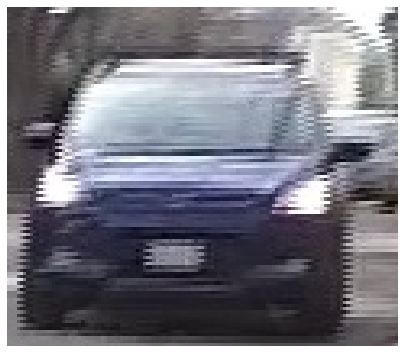

In [31]:
crop = cv2.imread(str(CROPPED_CARS_SAVE_DIR / 'ford_escape_2011_blue_02/frame10.jpg'))
plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [32]:
predict_class(crop)

'ford_escape_2011_blue'